In [1]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_printoptions(threshold=100)

In [32]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [33]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [34]:
#Specifying the paramenters of our model (ols - ordinary least squares i.e. linear regression)
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [35]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:29889024000.0
Coefficients:  tensor([[3.3032e+01, 1.1173e-02, 1.6113e-01, 3.2019e-01, 4.7043e+00]])
-------------------
2th epoch
Loss ols:38795599872.0
Coefficients:  tensor([[6.9708e+01, 4.3485e-02, 1.8754e-01, 5.9882e-01, 9.7254e+00]])
-------------------
3th epoch
Loss ols:30773739520.0
Coefficients:  tensor([[1.0256e+02, 6.8166e-02, 2.1024e-01, 9.3925e-01, 1.3945e+01]])
-------------------
4th epoch
Loss ols:58688897024.0
Coefficients:  tensor([[1.4750e+02, 9.6646e-02, 2.3292e-01, 1.5081e+00, 1.9511e+01]])
-------------------
5th epoch
Loss ols:44163383296.0
Coefficients:  tensor([[1.8386e+02, 1.2079e-01, 2.5332e-01, 1.8477e+00, 2.4070e+01]])


In [36]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [2]:
#Creating a class for displaying the results
class Evaluation_Cross_Entropy:
    """For evaluating the accuracy of image recognition neural networks"""
    def __init__(self,net,img = None,label = None):
        #History of saved error rates, used for in-sample error evaluation during neural network training
        self.hist = []
        self.net = net
        self.img = img
        self.label = label

    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(self.img).double()
        exp = torch.exp(output)
        sum = torch.sum(exp,dim=-1)
        probabilities = exp / sum.unsqueeze(1)
        return probabilities

    def pred(self):
        """Returns the labels our model predicted for each image"""
        pred = torch.argmax(self.prob(),dim=1)
        return pred

    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)

    def error(self):
        """Returns missclassificaiton eror rate"""
        return torch.sum(self.pred() != self.label)/len(self.label)

    def add(self,img,label):
        """Appends an error rate (and loss if not None) to the history of error rates (used for in-sample error rate during training)"""
        self.img = img
        self.label = label
        self.hist.append(self.error())


    def __getitem__(self, idx):
        return self.hist[idx]

    def plot(self):
        """Plots the in-sample error and loss (if such has been added) from history"""

        plt.plot(self.hist)
        plt.ylabel('In-sample error')
        plt.xlabel('Epoch')
        plt.show()


In [3]:
#Creating an automatic trainer to be used with sequential linear classes
class Gradient_Img_Trainer:
    """Automatic trainer for linear classifiers embedded through a sequential class"""
    def __init__(self,net,train_iter,loss,trainer,test_iter=None):
        self.net = net
        self.train_iter = train_iter
        self.loss = loss
        self.trainer = trainer
        self.test_iter = test_iter
        self.eval = None

    def normal_init(self, std = 0.1):
        """Used for initializing the weights of the nn from a normal distribution"""
        def init_normal(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=std)

        self.net.apply(init_normal)

    def xavier_uniform(self):
        """Used for initializing the weights of the nn according to a xavier method from a uniform"""
        def xavier(m):
            if type(m)== nn.Linear:
                nn.init.xavier_uniform_(m.weight)

        self.net.apply(xavier)

    def xavier_normal(self):
        """Used for initializing the weights of the nn according to a xavier method from a normal"""
        def xavier(m):
            if type(m)== nn.Linear:
                nn.init.xavier_normal_(m.weight)

        self.net.apply(xavier)


    def Train(self,num_epochs,ploss = False,perror = False,graph = False):
        """Used for training the neural network
                :param ploss: - print loss for each epoch
                :param perror: - print error for each epoch
                :param graph: - graph in-sample error at the end of training"""
        self.net.train()
        eval = Evaluation_Cross_Entropy(net=self.net)
        for epoch in range(num_epochs):
            if ploss is True or perror is True:
                print('-------------------')
                print(f'{epoch+1}th epoch')
                print('===================')
            self.net.zero_grad()
            img, label = next(iter(self.train_iter))
            output = self.net(img).double()
            l = self.loss(output,label)
            l.mean().backward()
            self.trainer.step()
            eval.add(img,label)
            if ploss is True:
                print("Loss:",l.sum().item())
            if perror is True:
                print("In-sample error:",eval.error())
        if graph is True:
            eval.plot()
        self.eval = eval

    def Test(self,test_iter=None):
        self.net.eval()
        if self.test_iter is None:
            self.test_iter = test_iter
        img, label = next(iter(self.test_iter))
        result = Evaluation_Cross_Entropy(net=self.net, img=img, label=label)
        print("Out-of-sample error:",result.error())
        self.result = result

In [4]:
#Loading in complex MNIST train and test datasets while transforming them to 28x28
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

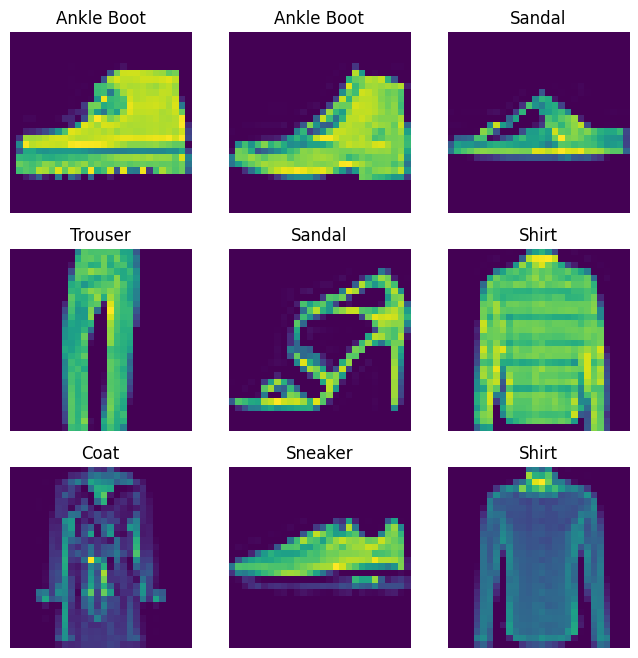

In [5]:
#Visualizing 9 random examples
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    imge, labele = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[labele])
    plt.axis("off")
    plt.imshow(imge.squeeze())
plt.show()

In [26]:
#Splitting our data into batch sizes
mnist_batch_size = 512

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4)

In [42]:
#Creating the model and initializing the weights (logit - logistic regression)
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

-------------------
1th epoch
Loss: 591.2272689823897
In-sample error: tensor(0.7695)
-------------------
2th epoch
Loss: 552.9257058530841
In-sample error: tensor(0.5820)
-------------------
3th epoch
Loss: 501.71620667351584
In-sample error: tensor(0.4570)
-------------------
4th epoch
Loss: 468.00634466954784
In-sample error: tensor(0.4258)
-------------------
5th epoch
Loss: 430.528454595545
In-sample error: tensor(0.3906)
-------------------
6th epoch
Loss: 401.3375790817794
In-sample error: tensor(0.3672)
-------------------
7th epoch
Loss: 393.4916565706266
In-sample error: tensor(0.3555)
-------------------
8th epoch
Loss: 363.9213251175978
In-sample error: tensor(0.3086)
-------------------
9th epoch
Loss: 372.200800312816
In-sample error: tensor(0.3672)
-------------------
10th epoch
Loss: 351.50464835372225
In-sample error: tensor(0.3594)
-------------------
11th epoch
Loss: 351.29984292557003
In-sample error: tensor(0.3711)
-------------------
12th epoch
Loss: 349.353048096

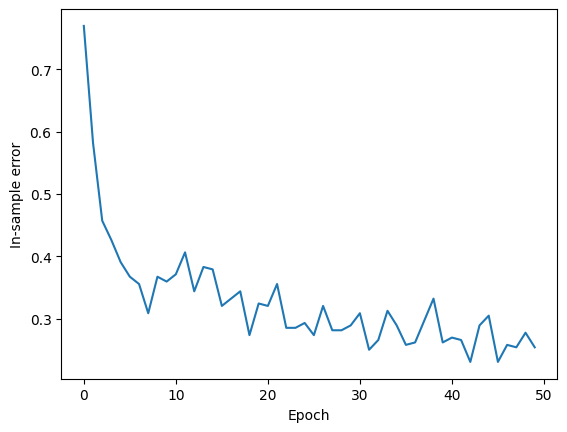

In [43]:
logit_training = Gradient_Img_Trainer(logit_net, mnist_train_iter, logit_loss, logit_trainer, mnist_test_iter)
logit_training.Train(50,True,True,True)

In [44]:
logit_training.Test()

Out-of-sample error: tensor(0.2808)


In [45]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [46]:
#Perceptron initiation

MLP = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

MLP.apply(init_weights)

MLP_loss = nn.CrossEntropyLoss(reduction='none')

MLP_trainer = torch.optim.SGD(MLP.parameters(),lr = 0.1)

-------------------
1th epoch
Loss: 589.3129363431881
In-sample error: tensor(0.8906)
-------------------
2th epoch
Loss: 588.0891849827242
In-sample error: tensor(0.8750)
-------------------
3th epoch
Loss: 585.9497013066683
In-sample error: tensor(0.8828)
-------------------
4th epoch
Loss: 584.7267565624908
In-sample error: tensor(0.8398)
-------------------
5th epoch
Loss: 582.608947428761
In-sample error: tensor(0.7695)
-------------------
6th epoch
Loss: 581.0240010379774
In-sample error: tensor(0.7188)
-------------------
7th epoch
Loss: 578.2369153019553
In-sample error: tensor(0.6250)
-------------------
8th epoch
Loss: 577.438456147366
In-sample error: tensor(0.6562)
-------------------
9th epoch
Loss: 574.0975469987625
In-sample error: tensor(0.6953)
-------------------
10th epoch
Loss: 572.0746901134472
In-sample error: tensor(0.7070)
-------------------
11th epoch
Loss: 567.9180621537311
In-sample error: tensor(0.6602)
-------------------
12th epoch
Loss: 565.0213340587513

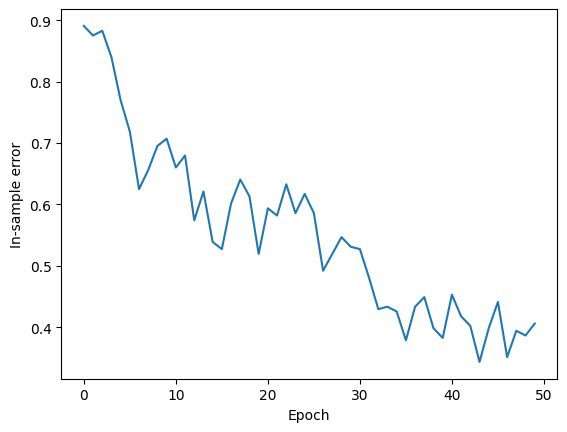

In [47]:
MLP_Training = Gradient_Img_Trainer(MLP, mnist_train_iter, MLP_loss, MLP_trainer, mnist_test_iter)
MLP_Training.Train(50,True,True,True)

In [48]:
MLP_Training.Test()

Out-of-sample error: tensor(0.4329)


In [49]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [50]:
#Running a logistic regression with weight decay

Wd_net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

Wd_net.apply(init_weights)

Wd_loss = nn.CrossEntropyLoss(reduction='none')

Weight_decay = 10

Wd_trainer = torch.optim.SGD([
    {"params":Wd_net[1].weight,'weight decay':Weight_decay},
    {"params":Wd_net[1].bias}],lr = 0.1)

-------------------
1th epoch
Loss: 584.7893581153643
In-sample error: tensor(0.7305)
-------------------
2th epoch
Loss: 527.3086460813738
In-sample error: tensor(0.5156)
-------------------
3th epoch
Loss: 491.0728709725405
In-sample error: tensor(0.5547)
-------------------
4th epoch
Loss: 478.96862840886615
In-sample error: tensor(0.4531)
-------------------
5th epoch
Loss: 433.8595048331514
In-sample error: tensor(0.4062)
-------------------
6th epoch
Loss: 429.41618486659286
In-sample error: tensor(0.4258)
-------------------
7th epoch
Loss: 389.47406380225743
In-sample error: tensor(0.3594)
-------------------
8th epoch
Loss: 371.77592651903035
In-sample error: tensor(0.3594)
-------------------
9th epoch
Loss: 363.27021157943517
In-sample error: tensor(0.3555)
-------------------
10th epoch
Loss: 342.4757699856971
In-sample error: tensor(0.3359)
-------------------
11th epoch
Loss: 323.191480133262
In-sample error: tensor(0.3125)
-------------------
12th epoch
Loss: 316.4208293

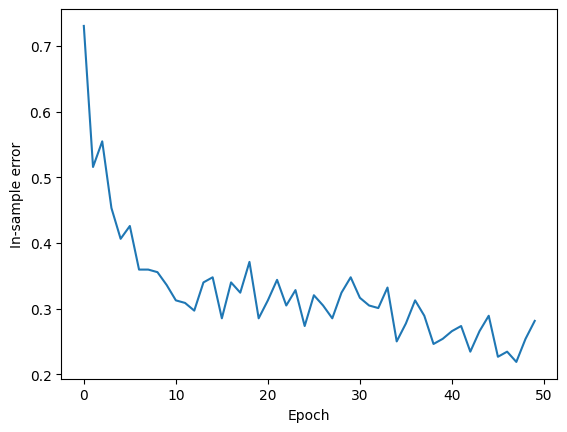

In [51]:
Wd_Training = Gradient_Img_Trainer(Wd_net, mnist_train_iter, Wd_loss, Wd_trainer, mnist_test_iter)
Wd_Training.Train(50,True,True,True)

In [52]:
Wd_Training.Test()

Out-of-sample error: tensor(0.2834)


In [ ]:
'''--------------------------------------------------------'''

In [11]:
#Multilayer Perceptron with Weight Decay and different parameters
WM_net = nn.Sequential(nn.Flatten(),
                        nn.Linear(784,256),
                        nn.Tanh(),
                        nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

WM_net.apply(init_weights)

WM_loss = nn.CrossEntropyLoss(reduction='none')

Weight_decay = 3

WM_trainer = torch.optim.SGD([
    {"params":WM_net[1].weight,'weight decay':Weight_decay},
    {"params":WM_net[1].bias}],lr = 0.1)

-------------------
1th epoch
Loss: 588.6388504763185
In-sample error: tensor(0.8984)
-------------------
2th epoch
Loss: 588.3417362157631
In-sample error: tensor(0.9062)
-------------------
3th epoch
Loss: 586.4666796461147
In-sample error: tensor(0.8945)
-------------------
4th epoch
Loss: 584.5877790585814
In-sample error: tensor(0.8672)
-------------------
5th epoch
Loss: 583.5587523113289
In-sample error: tensor(0.9062)
-------------------
6th epoch
Loss: 581.5892844433909
In-sample error: tensor(0.8867)
-------------------
7th epoch
Loss: 579.4491876490555
In-sample error: tensor(0.8438)
-------------------
8th epoch
Loss: 577.909404808732
In-sample error: tensor(0.8320)
-------------------
9th epoch
Loss: 575.6379447563099
In-sample error: tensor(0.7812)
-------------------
10th epoch
Loss: 573.8933557157857
In-sample error: tensor(0.7148)
-------------------
11th epoch
Loss: 572.6310487044029
In-sample error: tensor(0.7109)
-------------------
12th epoch
Loss: 570.483462875814

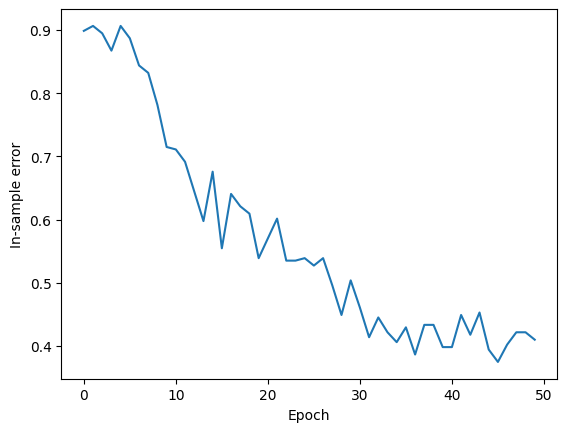

In [12]:
#Training MLP with weight decay
WM_Training = Gradient_Img_Trainer(WM_net,mnist_train_iter,WM_loss,WM_trainer,mnist_test_iter)
WM_Training.Train(50,True,True,True)

In [ ]:
'''--------------------------------------------------------'''

In [22]:
#MLP with Drop-out

Dropout_net = nn.Sequential(nn.Flatten(),
                            nn.Linear(784,256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(256,256),
                            nn.ReLU(0.5),
                            nn.Dropout(0.5),
                            nn.Linear(256,10)
                            )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

Dropout_net.apply(init_weights)

Dropout_loss = nn.CrossEntropyLoss(reduction='none')
Dropout_trainer = torch.optim.SGD(Dropout_net.parameters(), lr = 0.5)

-------------------
1th epoch
Loss: 589.6979523499665
In-sample error: tensor(0.9062)
-------------------
2th epoch
Loss: 588.5107049106989
In-sample error: tensor(0.8633)
-------------------
3th epoch
Loss: 588.4913904371328
In-sample error: tensor(0.8711)
-------------------
4th epoch
Loss: 588.9923198880233
In-sample error: tensor(0.8906)
-------------------
5th epoch
Loss: 588.4681541625126
In-sample error: tensor(0.8594)
-------------------
6th epoch
Loss: 588.7656427691295
In-sample error: tensor(0.8867)
-------------------
7th epoch
Loss: 588.2890994559613
In-sample error: tensor(0.8867)
-------------------
8th epoch
Loss: 587.5615559943494
In-sample error: tensor(0.8398)
-------------------
9th epoch
Loss: 589.4670929245061
In-sample error: tensor(0.8867)
-------------------
10th epoch
Loss: 587.4385176212947
In-sample error: tensor(0.8984)
-------------------
11th epoch
Loss: 586.0677062558009
In-sample error: tensor(0.8789)
-------------------
12th epoch
Loss: 586.53205207896

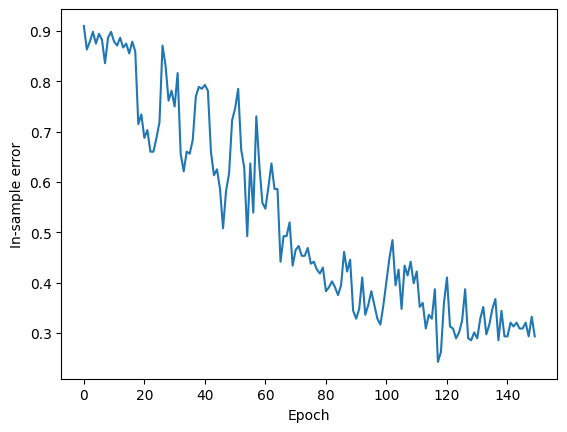

In [23]:
#Training with Drop-out
Dropout_training = Gradient_Img_Trainer(Dropout_net,mnist_train_iter,Dropout_loss,
                                        Dropout_trainer,mnist_test_iter)
Dropout_training.Train(150,True,True,True)

In [24]:
#Testing
Dropout_training.Test()

Out-of-sample error: tensor(0.2959)


In [ ]:
'''--------------------------------------------------------'''

In [28]:
#Basic CNN implementation
CNN = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120), nn.ReLU(),
    nn.Linear(120,84), nn.ReLU(),
    nn.Linear(84,10))

def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight)

CNN.apply(xavier_init)


CNN_loss = nn.CrossEntropyLoss(reduction='none')

CNN_trainer = torch.optim.SGD(CNN.parameters(),lr = 0.3)

-------------------
1th epoch
In-sample error: tensor(0.9453)
-------------------
2th epoch
In-sample error: tensor(0.8555)
-------------------
3th epoch
In-sample error: tensor(0.8418)
-------------------
4th epoch
In-sample error: tensor(0.8359)
-------------------
5th epoch
In-sample error: tensor(0.7305)
-------------------
6th epoch
In-sample error: tensor(0.7148)
-------------------
7th epoch
In-sample error: tensor(0.7383)
-------------------
8th epoch
In-sample error: tensor(0.7773)
-------------------
9th epoch
In-sample error: tensor(0.8828)
-------------------
10th epoch
In-sample error: tensor(0.7832)
-------------------
11th epoch
In-sample error: tensor(0.5605)
-------------------
12th epoch
In-sample error: tensor(0.6484)
-------------------
13th epoch
In-sample error: tensor(0.6211)
-------------------
14th epoch
In-sample error: tensor(0.6094)
-------------------
15th epoch
In-sample error: tensor(0.8828)
-------------------
16th epoch
In-sample error: tensor(0.9004)
-

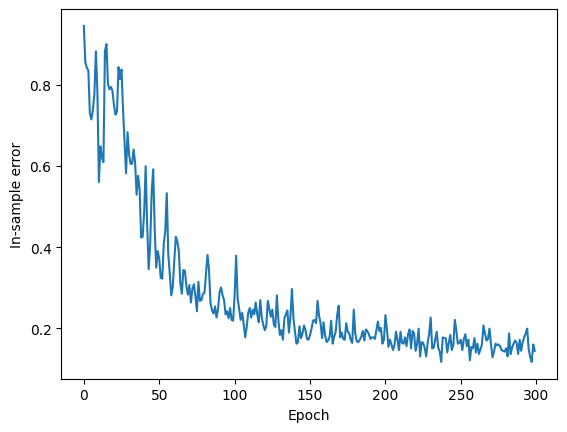

In [29]:
#Training of our CNN
CNN_training = Gradient_Img_Trainer(CNN,mnist_train_iter,CNN_loss,CNN_trainer,mnist_test_iter)
CNN_training.Train(300,perror=True,graph=True)

In [30]:
CNN_training.Test()

Out-of-sample error: tensor(0.1660)
